## CS582: End Semester Examination 
### Aditya Gupta
### 2403res85
### IITP002204

### Importing Libraries

In [1]:
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import nltk.translate.bleu_score as bleu
from io import open
import random
import warnings

warnings.filterwarnings("ignore")

### Checking MPS Device (Developed on a Macbook)

In [2]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


### A class for adding Words, Sentences and storing the mapping for Word2Index and vice versa.

In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3

    def add_sentence(self, sentence):
        for word in sentence.split(" "):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Utilities

In [4]:
class Utilities:
    def __init__(self):
        self.SOS_TOKEN = 0
        self.EOS_TOKEN = 1
        self.UNK_TOKEN = 2
        self.MAX_LENGTH = 30
        self.teacher_forcing_ratio = 0.5
        self.hidden_size = 1000

    @staticmethod
    def read_langs(lang1, lang2, reverse=False):
        print("Started Loading Data...")
        print("Reading lines...")
        lines = open("eng to hin.txt", encoding="utf-8").read().strip().split("\n")

        pairs = [[s for s in l.split("\t")[:2]] for l in lines]

        print("len", len(pairs))
        if reverse:
            pairs = [list(reversed(p)) for p in pairs]
            input_lang = Lang(lang2)
            output_lang = Lang(lang1)
        else:
            input_lang = Lang(lang1)
            output_lang = Lang(lang2)

        return input_lang, output_lang, pairs

    @staticmethod
    def filter_pairs(pairs):
        filtered_pairs = []
        for pair in pairs:
            try:
                if (
                    len(pair[0].split(" ")) < Utilities().MAX_LENGTH
                    and len(pair[1].split(" ")) < Utilities().MAX_LENGTH
                ):
                    filtered_pairs.append(pair)
            except:
                print("Skipped this pair : ", pair)

        return filtered_pairs

    @staticmethod
    def prepare_data(lang1, lang2, reverse=False):
        input_lang, output_lang, pairs = Utilities().read_langs(lang1, lang2, reverse)
        print("Read %s sentence pairs" % len(pairs))
        pairs = Utilities.filter_pairs(pairs)
        print("Trimmed to %s sentence pairs" % len(pairs))
        print("Counting words...")
        for pair in pairs:
            input_lang.add_sentence(pair[0])
            output_lang.add_sentence(pair[1])
        print("Counted words:")
        print(input_lang.name, input_lang.n_words)
        print(output_lang.name, output_lang.n_words)
        return input_lang, output_lang, pairs

    @staticmethod
    def indexes_from_sentence(lang, sentence):
        words = sentence.split(" ")
        indexes = []
        for word in words:
            if word not in lang.word2index.keys():
                indexes.append(lang.word2index["UNK"])
            else:
                indexes.append(lang.word2index[word])

        return indexes

    @staticmethod
    def tensor_from_sentence(lang, sentence):
        indexes = Utilities().indexes_from_sentence(lang, sentence)
        indexes.append(Utilities().EOS_TOKEN)
        return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

    @staticmethod
    def tensors_from_pair(input_lang, output_lang, pair):
        indexes = Utilities().indexes_from_sentence(input_lang, pair[0])
        indexes.append(Utilities().EOS_TOKEN)
        input_tensor = torch.tensor(indexes, dtype=torch.long, device=device).view(
            -1, 1
        )

        indexes = Utilities().indexes_from_sentence(output_lang, pair[1])
        indexes.append(Utilities().EOS_TOKEN)
        target_tensor = torch.tensor(indexes, dtype=torch.long, device=device).view(
            -1, 1
        )
        return (input_tensor, target_tensor)

    @staticmethod
    def train(
        input_tensor,
        target_tensor,
        encoder,
        decoder,
        encoder_optimizer,
        decoder_optimizer,
        criterion,
    ):
        encoder_hidden = encoder.init_hidden()

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(
            Utilities().MAX_LENGTH, encoder.hidden_size, device=device
        )

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[Utilities().SOS_TOKEN]], device=device)

        decoder_hidden = encoder_hidden

        use_teacher_forcing = (
            True if random.random() < Utilities().teacher_forcing_ratio else False
        )

        if use_teacher_forcing:
            for di in range(target_length):
                decoder_output, decoder_hidden, _ = decoder(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]

        else:
            for di in range(target_length):
                decoder_output, decoder_hidden, _ = decoder(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()

                loss += criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == Utilities().EOS_TOKEN:
                    break

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        return loss.item() / target_length

    @staticmethod
    def show_plot(points):
        plt.figure()
        fig, ax = plt.subplots()
        loc = ticker.MultipleLocator(base=0.2)
        ax.yaxis.set_major_locator(loc)
        plt.plot(points)
        plt.xlabel("steps")
        plt.ylabel("loss")
        plt.show()
        fig.savefig("loss.png")

    @staticmethod
    def as_minutes(s):
        m = math.floor(s / 60)
        s -= m * 60
        return "%dm %ds" % (m, s)

    @staticmethod
    def time_since(since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return "%s (- %s)" % (Utilities().as_minutes(s), Utilities().as_minutes(rs))

    @staticmethod
    def train_iters(
        input_lang,
        output_lang,
        encoder,
        decoder,
        n_iters,
        pairs,
        print_every=1000,
        plot_every=100,
        learning_rate=0.01,
    ):
        start = time.time()
        plot_losses = []
        print_loss_total = 0
        plot_loss_total = 0

        encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
        training_pairs = [
            Utilities().tensors_from_pair(input_lang, output_lang, random.choice(pairs))
            for i in range(n_iters)
        ]
        criterion = nn.NLLLoss()

        for iter in range(1, n_iters + 1):
            training_pair = training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = Utilities.train(
                input_tensor,
                target_tensor,
                encoder,
                decoder,
                encoder_optimizer,
                decoder_optimizer,
                criterion,
            )
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print(
                    "%s (%d %d%%) %.4f"
                    % (
                        Utilities().time_since(start, iter / n_iters),
                        iter,
                        iter / n_iters * 100,
                        print_loss_avg,
                    )
                )

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        Utilities().show_plot(plot_losses)

    @staticmethod
    def evaluate(encoder, decoder, sentence, input_lang, output_lang):
        max_length = Utilities().MAX_LENGTH
        with torch.no_grad():
            input_tensor = Utilities().tensor_from_sentence(input_lang, sentence)
            input_length = input_tensor.size()[0]
            encoder_hidden = encoder.init_hidden()

            encoder_outputs = torch.zeros(
                max_length, encoder.hidden_size, device=device
            )

            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(
                    input_tensor[ei], encoder_hidden
                )
                encoder_outputs[ei] += encoder_output[0, 0]

            decoder_input = torch.tensor(
                [[Utilities().SOS_TOKEN]], device=device
            )  # SOS

            decoder_hidden = encoder_hidden

            decoded_words = []
            decoder_attentions = torch.zeros(max_length, max_length)

            for di in range(max_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == Utilities().EOS_TOKEN:
                    decoded_words.append("<EOS>")
                    break
                else:
                    decoded_words.append(output_lang.index2word[topi.item()])

                decoder_input = topi.squeeze().detach()

            return decoded_words, decoder_attentions[: di + 1]

    @staticmethod
    def evaluate_randomly(encoder, decoder, pairs, input_lang, output_lang, n=10):
        for i in range(n):
            pair = random.choice(pairs)
            print(">", pair[0])
            print("=", pair[1])
            output_words, _ = Utilities().evaluate(
                encoder, decoder, pair[0], input_lang, output_lang
            )
            output_sentence = " ".join(output_words)
            print("<", output_sentence)
            # Bleu
            ref = [pair[1].split()]
            bl = bleu.sentence_bleu(ref, output_sentence.split())
            print("BLEU Score", bl)
            print("")

### Encoder RNN

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.embedding = nn.Embedding(input_size, hidden_size, layers)
        self.lstm = nn.LSTM(hidden_size, hidden_size, layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(
            self.layers, 1, self.hidden_size, device=device
        ), torch.zeros(self.layers, 1, self.hidden_size, device=device)

### Attention Decoder RNN

In [6]:
class AttnDecoderRNN(nn.Module):
    def __init__(
        self,
        hidden_size,
        output_size,
        dropout_p=0.1,
        max_length=Utilities().MAX_LENGTH,
        layers=1,
    ):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.layers = layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1
        )

        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0)
        )

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)

        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(
            self.layers, 1, self.hidden_size, device=device
        ), torch.zeros(self.layers, 1, self.hidden_size, device=device)

### Training the Model

Started Loading Data...
Reading lines...
len 2869
Read 2869 sentence pairs
Trimmed to 2869 sentence pairs
Counting words...
Counted words:
eng 3520
hin 3162
Data Loaded...
['Is that a cat?', 'वह बिल्ली है क्या?']
========== Building Encoder... ==========

EncoderRNN(
  (embedding): Embedding(3520, 1000, padding_idx=1)
  (lstm): LSTM(1000, 1000)
)




========== Building Decoder... ==========

AttnDecoderRNN(
  (embedding): Embedding(3162, 1000)
  (attn): Linear(in_features=2000, out_features=30, bias=True)
  (attn_combine): Linear(in_features=2000, out_features=1000, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(1000, 1000)
  (out): Linear(in_features=1000, out_features=3162, bias=True)
)




========== Starting Training... ==========

0m 17s (- 148m 20s) (100 0%) 4.4540
0m 21s (- 88m 18s) (200 0%) 4.4983
0m 25s (- 69m 26s) (300 0%) 5.1434
0m 29s (- 60m 34s) (400 0%) 5.1210
0m 33s (- 54m 59s) (500 1%) 5.0857
0m 37s (- 51m 48s) (600 1%) 5.2765
0m 41s (- 49m 2s) (7

<Figure size 640x480 with 0 Axes>

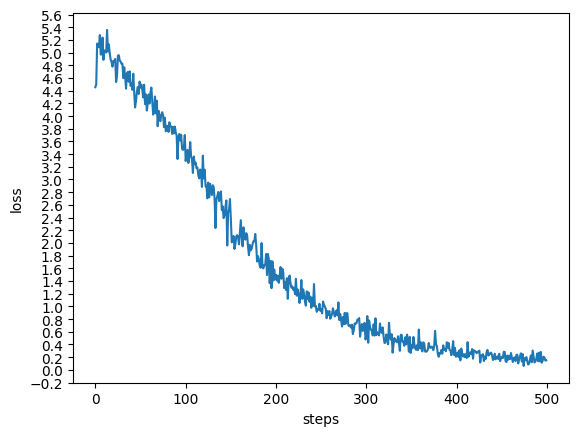

========== Finished Training... ==========



In [8]:
def run_training():
    input_lang, output_lang, pairs = Utilities().prepare_data(
                                                    "eng", 
                                                    "hin", 
                                                    False
                                                )
    print("Data Loaded...")
    print(random.choice(pairs))
    print("========== Building Encoder... ==========\n")
    encoder1 = EncoderRNN(
        input_lang.n_words, 
        Utilities().hidden_size, 
        layers=1
    ).to(device)
    print(encoder1)
    print("\n")
    print("\n")
    print("========== Building Decoder... ==========\n")
    attn_decoder1 = AttnDecoderRNN(
        Utilities().hidden_size, 
        output_lang.n_words, 
        dropout_p=0.1, 
        layers=1
    ).to(device)
    print(attn_decoder1)
    print("\n")
    print("\n")
    print("========== Starting Training... ==========\n")
    Utilities().train_iters(
        input_lang, 
        output_lang, 
        encoder1, 
        attn_decoder1, 
        50000, 
        pairs, 
        print_every=100
    )
    print("========== Finished Training... ==========\n")

    return encoder1, attn_decoder1


encoder1, attn_decoder1 = run_training()

### Random Testing with Bleu Score

In [9]:
input_lang, output_lang, pairs = Utilities().prepare_data(
                                                "eng", 
                                                "hin", 
                                                False
                                            )
print("Data Loaded...")
print(random.choice(pairs))

Utilities().evaluate_randomly(
    encoder1, 
    attn_decoder1, 
    pairs, 
    input_lang, 
    output_lang
)

Started Loading Data...
Reading lines...
len 2869
Read 2869 sentence pairs
Trimmed to 2869 sentence pairs
Counting words...
Counted words:
eng 3520
hin 3162
Data Loaded...
["He couldn't get the job.", 'उसको नौकरी नहीं मिल पायी।']
> You have the freedom to travel wherever you like.
= तुम्हारे पास जहाँ भी जाने की मर्ज़ी हो वहाँ जाने की आज़ादी है।
< तुम्हारे पास जहाँ भी की मर्ज़ी हो वहाँ जाने की आज़ादी है। <EOS>
BLEU Score 0.7611606003349892

> I'm satisfied with my current income.
= मैं अपनी वर्तमान आमदनी से संतुष्ट हूँ।
< मैं अपनी कमाई से संतुष्ट हूँ। हूँ। <EOS>
BLEU Score 5.614021910443866e-78

> According to TV news, there was a plane crash in India.
= टीवी समाचार के मुताबिक, भारत में विमान दुर्घटना हुई है।
< टीवी समाचार के मुताबिक, भारत में विमान दुर्घटना हुई है। <EOS>
BLEU Score 0.8931539818068694

> He is a nice man, except that he talks too much.
= वह आदमी तो भला है, पर बात बहुत ज़्यादा करता है।
< वह आदमी तो भला है, पर बात बहुत ज़्यादा करता है। <EOS>
BLEU Score 0.9036020036098448
